In [200]:
import netCDF4
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py as h5
import utils as ut
from pyhdf.SD import SD, SDC
from matplotlib import colors
from mpl_toolkits.basemap import Basemap

## Loading MODIS Data

In [187]:
def getclosest_ij(lats,lons,latpt,lonpt):
    """
    function to get the index of the nearest grid point to a given lat/lon point
    input: lats,lons: 2D arrays of lat/lon values
    output: i,j: indices of the nearest grid point
    """
    dist_sq = (lats-latpt)**2 + (lons-lonpt)**2
    minindex_flattened = dist_sq.argmin()
    return np.unravel_index(minindex_flattened, lats.shape)

In [249]:
f = netCDF4.Dataset('./files/MODIS/A2022002.L3m_DAY_CHL_chlor_a_4km.nc')

In [250]:
chlor = np.array(f.variables['chlor_a'][:])
lat = np.array(f.variables['lat'][:])
lon = np.array(f.variables['lon'][:])
palette = np.array(f.variables['palette'][:])

In [251]:
modis_df = pd.DataFrame(chlor, index=lat, columns=lon)
modis_df.index.name = 'lat'
modis = pd.melt(modis_df.reset_index(), id_vars=['lat'], value_vars=lon)
modis.columns = ['lat', 'lon', 'chlor_a']
modis.replace(-32767.0, 0, inplace=True)
modis.head()

,lat,lon,chlor_a
0,89.979164,-179.979172,0.0
1,89.937500,-179.979172,0.0
2,89.895836,-179.979172,0.0
3,89.854164,-179.979172,0.0
4,89.812500,-179.979172,0.0


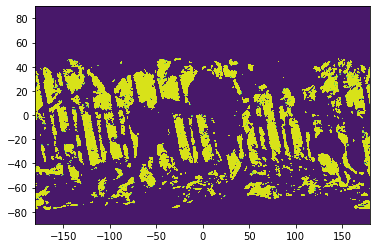

In [252]:
cs = plt.contourf(lon, lat, chlor)

In [272]:
modis.sort_values(by='chlor_a', inplace=True, ascending=False)
modis.head(20)

,lat,lon,chlor_a
20146912,-24.687504,14.312506,95.409943
22059527,23.020832,32.77084,93.533234
22059526,23.062498,32.77084,93.527824
17696102,32.395832,-9.312495,91.350136
22055207,23.020832,32.729172,87.776634
22055206,23.062498,32.729172,87.770615
21960179,22.520832,31.812506,87.397522
21964499,22.520832,31.854174,87.397522
21964498,22.562498,31.854174,87.397522
21960178,22.562498,31.812506,87.397522


## Loading Icesat-2 Data

In [198]:
def getATL03data(fileT, numpyout=False, beam='gt1l'):
    """ Pandas/numpy ATL03 reader
    Written by Alek Petty, June 2018 (alek.a.petty@nasa.gov)

    I've picked out the variables from ATL03 I think are of most interest to sea ice users, but by no
    means is this an exhastive list. 
    See the xarray or dictionary readers to load in the more complete ATL03 dataset
    or explore the hdf5 files themselves (I like using the app Panpoly for this) to see what else you
    might want
    
    Args:
        fileT (str): File path of the ATL03 dataset
        numpy (flag): Binary flag for outputting numpy arrays (True) or pandas dataframe (False)
        beam (str): ICESat-2 beam (the number is the pair, r=strong, l=weak)
        
    returns:
        either: select numpy arrays or a pandas dataframe

    """
    
    # Open the file
    try:
        ATL03 = h5.File(fileT, 'r')
    except:
        print('Not a valid file')
        
    lons=ATL03[beam+'/heights/lon_ph'][:]
    lats=ATL03[beam+'/heights/lat_ph'][:]
    
    #  Number of seconds since the GPS epoch on midnight Jan. 6, 1980 
    delta_time=ATL03[beam+'/heights/delta_time'][:] 
    
    # #Add this value to delta time parameters to compute the full gps_seconds
    atlas_epoch=ATL03['/ancillary_data/atlas_sdp_gps_epoch'][:] 
    
    # Conversion of delta_time to a calendar date
    # This function seems pretty convoluted but it works for now..
    # Sure there is a simpler functionw e can use here instead.
    temp = ut.convert_GPS_time(atlas_epoch[0] + delta_time, OFFSET=0.0)
    
    # Express delta_time relative to start time of granule
    delta_time_granule=delta_time-delta_time[0]
    year = temp['year'][:].astype('int')
    month = temp['month'][:].astype('int')
    day = temp['day'][:].astype('int')
    hour = temp['hour'][:].astype('int')
    minute = temp['minute'][:].astype('int')
    second = temp['second'][:].astype('int')
    dFtime=pd.DataFrame({'year':year, 'month':month, 'day':day, 
                        'hour':hour, 'minute':minute, 'second':second})
    # Primary variables of interest
    # Photon height
    heights=ATL03[beam+'/heights/h_ph'][:]
    print(heights.shape)
    
    # Flag for signal confidence
    # column index:  0=Land; 1=Ocean; 2=SeaIce; 3=LandIce; 4=InlandWater
    # values:
        #-- -1: Events not associated with a specific surface type
        #--  0: noise
        #--  1: buffer but algorithm classifies as background
        #--  2: low
        #--  3: medium
        #--  4: high
    signal_confidence=ATL03[beam+'/heights/signal_conf_ph'][:,2] 
    # Add photon rate, background rate etc to the reader here if we want
    ATL03.close()
    
    dF = pd.DataFrame({'heights':heights, 'lons':lons, 'lats':lats,
                       'signal_confidence':signal_confidence, 
                       'delta_time':delta_time_granule})
    
    # Add the datetime string
    dFtimepd=pd.to_datetime(dFtime)
    dF['datetime'] = pd.Series(dFtimepd, index=dF.index)
    
    # Filter out high elevation values 
    #dF = dF[(dF['signal_confidence']>2)]
    # Reset row indexing
    #dF=dF.reset_index(drop=True)
    return dF

In [199]:
icesat = getATL03data('./files/ICESAT2/ATL03_20181014083516_02400107_005_01.h5', beam='gt3r')
icesat.head()

(6017971,)


,heights,lons,lats,signal_confidence,delta_time,datetime
0,-43.993500,-74.18222,27.002162,-1,0.0,2018-10-14 08:35:16
1,-44.422836,-74.18222,27.002162,-1,0.0,2018-10-14 08:35:16
2,-43.922752,-74.18222,27.002162,-1,0.0,2018-10-14 08:35:16
3,-44.071194,-74.18222,27.002162,-1,0.0,2018-10-14 08:35:16
4,-44.020119,-74.18222,27.002162,-1,0.0,2018-10-14 08:35:16


## Loading CALIPSO Data

In [202]:
FILE_NAME = './files/CALIPSO/CAL_LID_L1-Standard-V4-11.2022-01-01T00-47-36ZN.hdf'
DATAFIELD_NAME = 'Perpendicular_Attenuated_Backscatter_532'
hdf = SD(FILE_NAME, SDC.READ)        

In [203]:
[x for x in list(hdf.datasets().keys()) if 'dep' in x.lower()]

['Depolarization_Gain_Ratio_532', 'Depolarization_Gain_Ratio_Uncertainty_532']

In [204]:
latitude = hdf.select('Latitude')
lat = latitude[:]
longitude = hdf.select('Longitude')
lon = longitude[:]

In [205]:
calipso_data = hdf.select(DATAFIELD_NAME)
calipso_np = calipso_data[:,:].astype(np.float64)

In [207]:
calipso_np.shape

(55350, 583)

In [229]:
backscatter = pd.DataFrame(calipso_np)
backscatter.columns = [f'backscatter_ind{i}' for i in range(1, backscatter.shape[1]+1)]
backscatter['lat'] = lat
backscatter['lon'] = lon
backscatter.head()

,backscatter_ind1,backscatter_ind2,backscatter_ind3,backscatter_ind4,backscatter_ind5,backscatter_ind6,backscatter_ind7,backscatter_ind8,backscatter_ind9,backscatter_ind10,...,backscatter_ind576,backscatter_ind577,backscatter_ind578,backscatter_ind579,backscatter_ind580,backscatter_ind581,backscatter_ind582,backscatter_ind583,lat,lon
0,-9999.0,-6.964199e-07,-9.396067e-07,0.000001,-0.000004,-1.353195e-07,4.370623e-07,0.000001,-0.000001,0.000002,...,0.000357,0.000320,0.000332,0.000133,0.000037,0.000029,0.000013,0.000006,71.786903,-179.192398
1,-9999.0,-6.965104e-07,-9.397287e-07,0.000001,-0.000004,-1.353370e-07,4.371191e-07,0.000001,-0.000001,0.000002,...,0.002148,0.001854,0.002678,0.000683,0.000262,0.000107,0.000060,0.000025,71.789558,-179.197021
2,-9999.0,-6.966011e-07,-9.398510e-07,0.000001,-0.000004,-1.353547e-07,4.371760e-07,0.000001,-0.000001,0.000002,...,0.002107,0.002162,0.001657,0.000762,0.000246,0.000164,0.000067,0.000047,71.792206,-179.201645
3,-9999.0,-6.966916e-07,-9.399732e-07,0.000001,-0.000004,-1.353722e-07,4.372328e-07,0.000001,-0.000001,0.000002,...,0.002727,0.002140,0.002044,0.000776,0.000284,0.000099,0.000054,0.000077,71.794861,-179.206284
4,-9999.0,-6.967823e-07,-9.400956e-07,0.000001,-0.000004,-1.353899e-07,4.372897e-07,0.000001,-0.000001,0.000002,...,0.002261,0.001993,0.001719,0.000920,0.000270,0.000129,0.000131,0.000086,71.797516,-179.210907


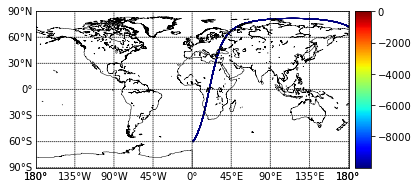

In [244]:
m = Basemap(projection='cyl', resolution='l',
                llcrnrlat=-90, urcrnrlat=90,
                llcrnrlon=-180, urcrnrlon=180)
m.drawcoastlines(linewidth=0.5)
m.drawparallels(np.arange(-90, 91, 30), labels=[1, 0, 0, 0])
m.drawmeridians(np.arange(-180, 181, 45), labels=[0, 0, 0, 1])
sc = m.scatter(lon, lat, c=calipso_np[:,0], s=1,
               cmap=plt.cm.jet,
               edgecolors=None, linewidth=0)
cb = m.colorbar()

basename = os.path.basename(FILE_NAME)
fig = plt.gcf()
pngfile = "{0}.py.png".format(basename)
plt.show()